In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
import seaborn as sns

In [2]:
from keras.layers import GRU
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/Users/kwonheejin/Documents/DL/dataset/HAR/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/Users/kwonheejin/Documents/DL/dataset/HAR/UCI HAR Dataset/')
    
    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [4]:
from tensorflow.keras.utils import plot_model

In [5]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [6]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print(longX.shape)
    pyplot.figure()
    xaxis = None
    for i in range(longX.shape[1]):
        ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        pyplot.hist(longX[:, i], bins=100)
    pyplot.show()

In [7]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [8]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(GRU(100, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [9]:
for layer in model.layers:
    print(layer.name)
    print(layer.input_shape)
    print(layer.output_shape)
    print(layer.get_config())
    print("\n")

gru
(None, 128, 9)
(None, 100)
{'name': 'gru', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 128, 9), 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 100, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'implementatio

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 8s 75ms/step - loss: 1.2954 - accuracy: 0.4562 - val_loss: 1.1224 - val_accuracy: 0.5452
Epoch 2/10
92/92 [==============================] - 6s 67ms/step - loss: 0.9475 - accuracy: 0.5970 - val_loss: 0.8859 - val_accuracy: 0.7179
Epoch 3/10
92/92 [==============================] - 6s 64ms/step - loss: 0.6533 - accuracy: 0.7218 - val_loss: 0.6647 - val_accuracy: 0.7458
Epoch 4/10
92/92 [==============================] - 6s 67ms/step - loss: 0.4178 - accuracy: 0.8301 - val_loss: 0.5013 - val_accuracy: 0.8321
Epoch 5/10
92/92 [==============================] - 6s 67ms/step - loss: 0.2963 - accuracy: 0.8890 - val_loss: 0.3195 - val_accuracy: 0.8939
Epoch 6/10
92/92 [==============================] - 6s 68ms/step - loss: 0.2026 - accuracy: 0.9274 - val_loss: 0.3112 - val_accuracy: 0.9089
Epoch 7/10
92/92 [==============================] - 6s 70ms/step - loss: 0.1802 - accuracy: 0.9327 - val_loss: 0.2972 - val_accuracy: 0.9055
Epoch 8/10
92

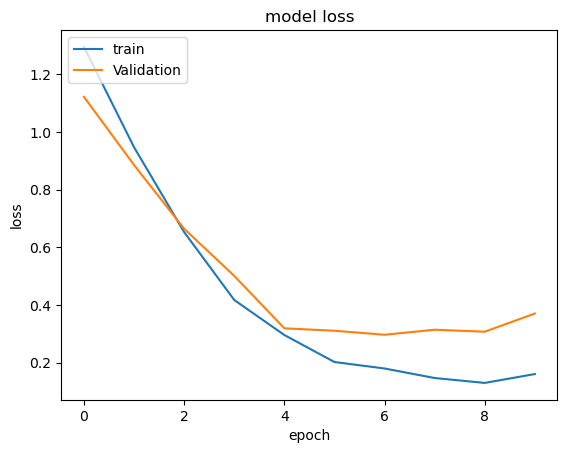

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [13]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8893790245056152
93/93 [==============================] - 2s 18ms/step


In [14]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[461  23  11   0   1   0]
 [ 10 432  29   0   0   0]
 [  6   9 404   0   1   0]
 [  3   3   0 422  63   0]
 [  5   0   0 135 392   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.95      0.93      0.94       496
           2       0.87      0.92      0.90       471
           3       0.91      0.96      0.94       420
           4       0.76      0.86      0.81       491
           5       0.86      0.74      0.79       532
           6       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



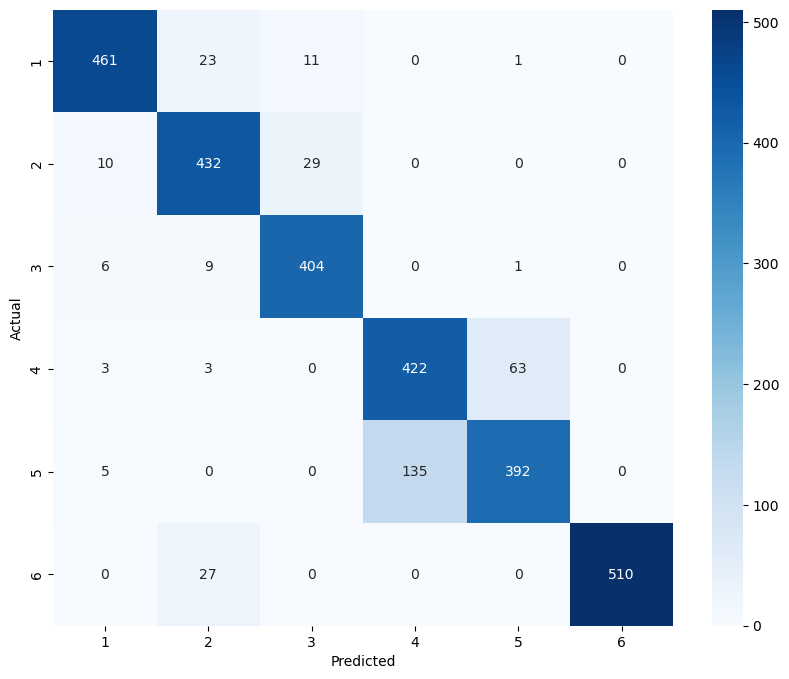

In [15]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)